In [1]:
pip install transformers

     |████████████████████████████████| 3.1 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 37.1 MB/s 
     |████████████████████████████████| 895 kB 38.2 MB/s 
     |████████████████████████████████| 3.3 MB 45.6 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping

from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification

In [3]:
df = pd.read_csv('train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df.shape

(7613, 5)

In [5]:
# only keeping text features
df = df.drop(['id','keyword','location'], axis=1)

In [6]:
duplicate_dict = {}
for num, row in df[df['text'].duplicated()].iterrows():
    if row['text'] not in duplicate_dict:
        duplicate_dict[row['text']] = [row['target']]
    else:
        duplicate_dict[row['text']].append(row['target'])
duplicate_dict

opp_target = []
for k,v in duplicate_dict.items():
    if all(x == v[0] for x in v):
        pass
    else:
        opp_target.append(k)
index_list = []
for i in opp_target:
    for j in list(df[df['text'].str.contains(i)].index.values):
        index_list.append(j)

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [7]:
df.shape

(7613, 2)

In [8]:
df = df.drop(np.array(index_list), axis=0)
df.shape

(7580, 2)

In [9]:
df = df.drop_duplicates(subset = 'text', keep='first') # we remove 1 of each of the remaining duplicate pairs
df.shape

(7493, 2)

In [10]:
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


### Splitting Data

In [11]:
df_train, df_test = train_test_split(df, test_size=.1, random_state=1)
df_train, df_val = train_test_split(df_train, test_size=df_test.shape[0]/df_train.shape[0], 
                                    random_state=1)

In [12]:
df_train.shape, df_val.shape, df_test.shape

((5993, 2), (750, 2), (750, 2))

In [13]:
df_train.head()

,text,target
4669,@ZachLowe_NBA there are a few reasons for that...,0
1593,'I'm there!' Bride &amp; Groom on mountain cli...,0
1039,Nine giant body sized garbage bags later...I'm...,0
923,Woke up so blown lol,0
3279,I need a spot w| some drink specials. I'm kind...,0


In [14]:
df_train['target'].dtype

dtype('int64')

### Tokenization for BERT 

In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [16]:
tokenizer('This is an emergency!!!')

{'input_ids': [101, 2023, 2003, 2019, 5057, 999, 999, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [17]:
for row in df_test.itertuples():
  text = row[1]
  label = row[2]
  tokenized = tokenizer(text, 
                                  max_length=128, 
                                  padding='max_length', 
                                  truncation=True)
  # print(tokenized)

In [18]:
def data_gen(data):
    def g():
        for row in data.itertuples():
            text = row[1]
            label = row[2]
            tokenized = tokenizer(text, 
                                  max_length=128, 
                                  padding='max_length', 
                                  truncation=True)
            yield {k: np.array(tokenized[k]) for k in tokenized}, label
    return g

input_names = ['input_ids', 'token_type_ids', 'attention_mask']
data_types = ({k: tf.int32 for k in input_names}, tf.int64)
data_shapes = ({k: tf.TensorShape([None]) for k in input_names}, tf.TensorShape([]))

data_train = tf.data.Dataset.from_generator(
    data_gen(df_train),
    data_types, data_shapes
).shuffle(100).batch(32).repeat(4)

data_val = tf.data.Dataset.from_generator(
    data_gen(df_val),
    data_types, data_shapes).shuffle(100).batch(32)

In [19]:
data_train.take(1)

<TakeDataset shapes: ({input_ids: (None, None), token_type_ids: (None, None), attention_mask: (None, None)}, (None,)), types: ({input_ids: tf.int32, token_type_ids: tf.int32, attention_mask: tf.int32}, tf.int64)>

In [20]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
opt = optimizers.Adam(learning_rate=3e-5)
scce = losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=scce, metrics='accuracy')

In [22]:
ES = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   patience=3,
                   restore_best_weights=True)

history = model.fit(data_train,  
          validation_data=data_val,
          epochs=20, 
          steps_per_epoch=64, 
          callbacks=ES)

Epoch 1/20
64/64 [==============================] - 138s 2s/step - loss: 0.5554 - accuracy: 0.7271 - val_loss: 0.4448 - val_accuracy: 0.8200
Epoch 2/20
64/64 [==============================] - 111s 2s/step - loss: 0.4160 - accuracy: 0.8267 - val_loss: 0.4022 - val_accuracy: 0.8320
Epoch 3/20
64/64 [==============================] - 110s 2s/step - loss: 0.4217 - accuracy: 0.8242 - val_loss: 0.4452 - val_accuracy: 0.8200
Epoch 4/20
64/64 [==============================] - 111s 2s/step - loss: 0.3752 - accuracy: 0.8511 - val_loss: 0.4081 - val_accuracy: 0.8253
Epoch 5/20
64/64 [==============================] - 111s 2s/step - loss: 0.3095 - accuracy: 0.8867 - val_loss: 0.4376 - val_accuracy: 0.8293


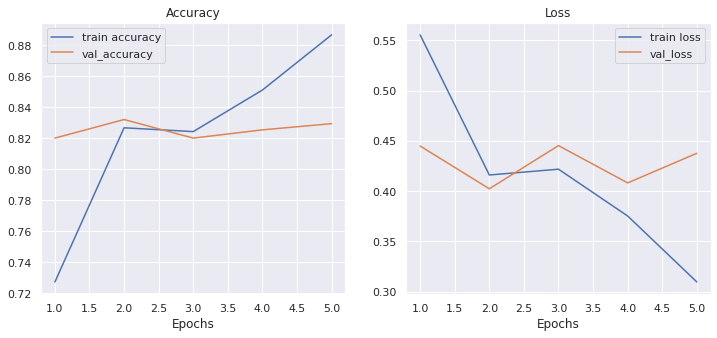

In [23]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, len(history.history['val_accuracy'])+1), 
         history.history['accuracy'], 
         label='train accuracy')
plt.plot(range(1, len(history.history['val_accuracy'])+1), 
         history.history['val_accuracy'], 
         label='val_accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')

plt.subplot(1,2,2)
plt.plot(range(1, len(history.history['val_accuracy'])+1), 
         history.history['loss'], 
         label='train loss')
plt.plot(range(1, len(history.history['val_accuracy'])+1), 
         history.history['val_loss'], 
         label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.title('Loss')
plt.show()



In [24]:
model.save_pretrained('BERT_model')

### Evaluation

In [25]:
from scipy.special import softmax

In [26]:
data_test = tf.data.Dataset.from_generator(
    data_gen(df_test),
    data_types, data_shapes).batch(32)

In [27]:
model.evaluate(data_test)

24/24 [==============================] - 13s 548ms/step - loss: 0.3842 - accuracy: 0.8360


[0.3841532766819, 0.8360000252723694]

In [28]:
predictions = model.predict(data_test)
predictions

TFSequenceClassifierOutput([('logits', array([[ 0.61343294, -0.65847415],
                                    [ 1.042322  , -0.8217269 ],
                                    [ 0.32656184, -0.340455  ],
                                    ...,
                                    [-1.1807206 ,  0.73478955],
                                    [ 1.1835778 , -0.8153327 ],
                                    [ 1.1012237 , -0.79617083]], dtype=float32))])

In [29]:
pred_scores = softmax(predictions[0], axis=1)[:,1]

In [30]:
pred_targets = np.where(pred_scores >= .5, 1, 0)

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [32]:
print(classification_report(df_test['target'], pred_targets))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       418
           1       0.86      0.75      0.80       332

    accuracy                           0.84       750
   macro avg       0.84      0.83      0.83       750
weighted avg       0.84      0.84      0.83       750



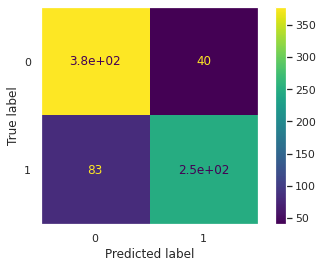

In [33]:
cm = confusion_matrix(df_test['target'], pred_targets, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.grid(None)
plt.show()

In [34]:
from sklearn.metrics import plot_roc_curve, roc_curve, precision_recall_curve, roc_auc_score

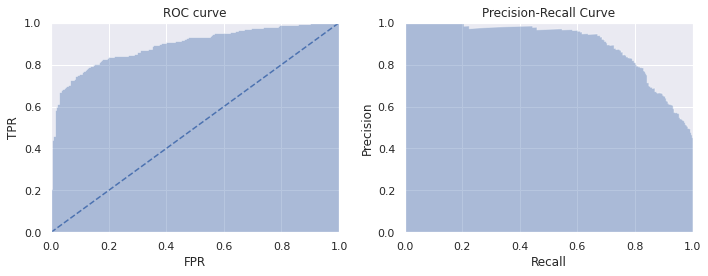

In [35]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
fpr = roc_curve(df_test['target'], pred_scores)[0]
tpr = roc_curve(df_test['target'], pred_scores)[1]
plt.fill_between(fpr,tpr,alpha=.4)
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle='dashed')
plt.ylim(0,1)
plt.xlim(0,1)

plt.subplot(1,2,2)
prec = precision_recall_curve(df_test['target'], pred_scores)[0]
recall = precision_recall_curve(df_test['target'], pred_scores)[1]

plt.fill_between(recall, prec, alpha=.4)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,1)
plt.ylim(0,1)

plt.tight_layout()
plt.show()

### Evaluating on new tweets

In [36]:
def make_prediction(tweet_text):
  # Can only handle one tweet at a time
  tokenized_tweet = tokenizer(tweet_text)
  logits = model.predict({k: np.array(tokenized_tweet[k])[None] for k in input_names})[0]

  scores = softmax(logits)
  if scores.flatten()[1] >= .5:
    return ('Emergency', scores.flatten()[1])
  else:
    return ('Non-Emergency', scores.flatten()[1])

In [37]:
make_prediction("I bought a new phone today. It's killer")

('Non-Emergency', 0.13077506)

In [38]:
make_prediction("Help!!! I'm stuck inside a burning building!!")

('Emergency', 0.63848263)

In [39]:
make_prediction("Fire reported in California")

('Emergency', 0.9811589)